In [165]:
from scipy.stats import ttest_1samp, norm, t, kstest, shapiro, mannwhitneyu
import statsmodels.api as sm 
import numpy  as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

import pandas as pd

In [166]:
df = pd.read_csv("А_B_cookie_cats 2.csv", sep=',', encoding='windows-1251')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [168]:
# общее количество пользователей
df["userid"].nunique()

90189

In [169]:
# посмотрели разделение по группам
df.version.value_counts()

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

In [170]:
retention = df[["retention_1","retention_7"]].mean()*100
retention
# процент юзеров от общего числа юзеров - удержание: 1 день,  7 дней

retention_1    44.520950
retention_7    18.606482
dtype: float64

In [171]:
# удержание юзеров (через 1 день, 7 дней) и общее число сыгранных раундов, в зависимости от версии продукта 
retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
retention_ab
# по таблице видно что, 

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

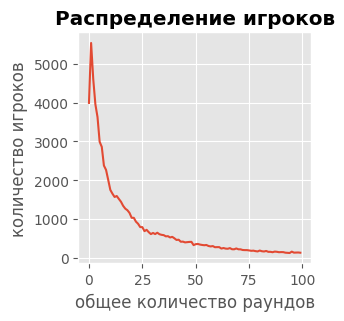

In [173]:
# по графику посмотрим распределение игроков в зависимости от количества пройденных раундов
plt.figure(figsize=(3, 3))
plot_df = df.groupby("sum_gamerounds")["userid"].count()
ax = plot_df.head(100).plot()

plt.title("Распределение игроков",  fontweight="bold")
plt.xlabel("общее количество раундов")
plt.ylabel("количество игроков")
plt.show()
# по графику видим, что много юзеров просто скачивают игру, но не играют в дальнейшем 

In [174]:
control_group = df['sum_gamerounds'][df['version'] == 'gate_30']
test_group = df['sum_gamerounds'][df['version'] == 'gate_40']

In [175]:
# распределение не является нормальным
print(shapiro(control_group))
print(shapiro(test_group))

ShapiroResult(statistic=0.08805108070373535, pvalue=0.0)
ShapiroResult(statistic=0.48256635665893555, pvalue=0.0)


In [176]:
import scipy.stats as stats

In [177]:
# по ttest_ind статистически значимых различий не выявлено, так как
# pvalue > alpha
stats.ttest_ind(control_group, test_group, equal_var = False)

TtestResult(statistic=0.8854374331270672, pvalue=0.37592438409326223, df=58595.481422574)

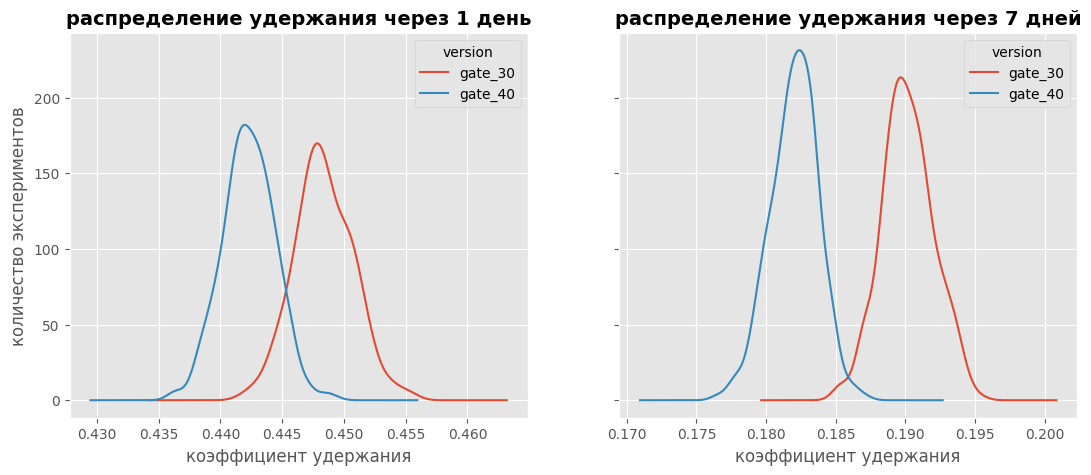

In [179]:
# далее все я взяла из описания А/В теста и разобрала
# Создание списка для каждой группы A/B
boot_1d = []
boot_7d = []
for i in range(500):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
# Трансформация списка в дата фрейм
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

# График оценки
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("коэффициент удержания",size=12)
ax1.set_ylabel("количество экспериментов",size=12)
ax1.set_title("распределение удержания через 1 день", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("коэффициент удержания",size=12)
ax2.set_title("распределение удержания через 7 дней", fontweight="bold",size=14)
plt.show()

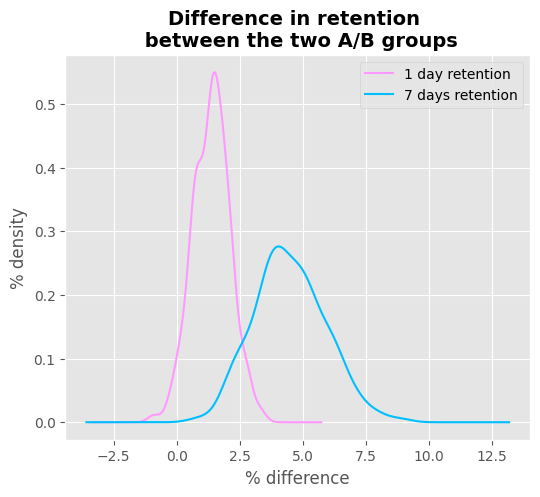

In [180]:
# Добавление столбца с разницей в % между двумя группами A/B
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

# Построение графика разницы в процентах
fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% Разница",size=12)
ax1.set_ylabel("% Плотность",size=12)
ax1.set_title("Разница в удержании между двумя группами A/B", fontweight="bold", size=14)
plt.legend()
plt.show()

In [183]:
# Вычисление вероятности того, что задержка на 1 день будет больше, когда ворота находятся на уровне 30
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])

# Вычисление вероятности того, что 7-дневное удержание будет больше, когда ворота находятся на уровне 30
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

# Хорошенькая распечатка вероятности
print(f"Вероятность удержания в течение 1 дня выше, когда ворота находятся на уровне 30: {round(prob_1,2)*100}% \
      \nВероятность того, что 7-дневное удержание будет больше, когда ворота находятся на уровне 30: {(prob_7)*100}% ")

Вероятность удержания в течение 1 дня выше, когда ворота находятся на уровне 30: 97.0%       
Вероятность того, что 7-дневное удержание будет больше, когда ворота находятся на уровне 30: 100.0% 


Результат начальной загрузки говорит нам о том, что есть убедительные доказательства 99,8% вероятности того, что 7-дневное удержание выше, когда ворота находятся на 30-м уровне, чем когда они находятся на 40-м.

Вывод таков: если мы хотим сохранить высокий уровень удержания — как на 1 день, так и на 7 дней, - нам не следует перемещать ворота с 30-го на 40—й уровень. Конечно, есть и другие показатели, на которые мы могли бы обратить внимание, например, количество сыгранных игровых раундов или объем внутриигровых покупок, совершенных двумя AB-группами. Но удержание - один из самых важных показателей.